*08/12/24*

Here we only fit the flux, this is a way to get familiar with blackjax and check if it parallelizes with NUTS / HMC.

In [1]:
import jax 
import jax.numpy as jnp
import blackjax
import galsim 
import jax_galsim as xgalsim
import arviz
import matplotlib.pyplot as plt
from jax.scipy import stats

from datetime import date

2024-08-13 08:13:51.530670: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
2024-08-13 08:14:00.923437: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from jax import jit as jjit

In [3]:
import chainconsumer as cc

In [4]:
jax.devices()

[CudaDevice(id=0), CudaDevice(id=1), CudaDevice(id=2), CudaDevice(id=3)]

In [5]:
jax.config.update("jax_enable_x64", True) # fair comparison with GalSim, among other reasons

# Setup

In [6]:
def get_snr(im, background):
    """Calculate the signal-to-noise ratio of an image.

    Args:
        im: Image array with no background.
        background: Background level.
    """

    return np.sqrt(np.sum(im * im / (background + im)))

In [7]:
import numpy as np


def add_noise(x: np.ndarray, bg: float, n=1, noise_factor=1):
    """Produce `n` independent Gaussian noise realizations of a given image `x`.

    NOTE: This function assumes image is background-subtracted and dominated.
    """
    x = x.reshape(1, *x.shape)
    x = x.repeat(n, axis=0)
    noise = np.random.randn(*x.shape) * np.sqrt(bg) * noise_factor
    return x + noise, noise

# Drawing methods

In [8]:
# constant galaxy parameters to fit 

PIXEL_SCALE = 0.2
PSF_HLR = 0.7
LOG_FLUX = 4.7
HLR = 0.9
BACKGROUND = 1e4
SLEN= 53

TRUE_PARAMS = {'f': LOG_FLUX}

In [9]:
def _draw_gal():
    gal = galsim.Gaussian(flux=10**LOG_FLUX, half_light_radius=HLR)
    psf = galsim.Gaussian(flux=1., half_light_radius=PSF_HLR)
    gal_conv = galsim.Convolve([gal, psf])
    image = gal_conv.drawImage(nx=SLEN,ny=SLEN,scale=PIXEL_SCALE,
                                 )
    return image.array

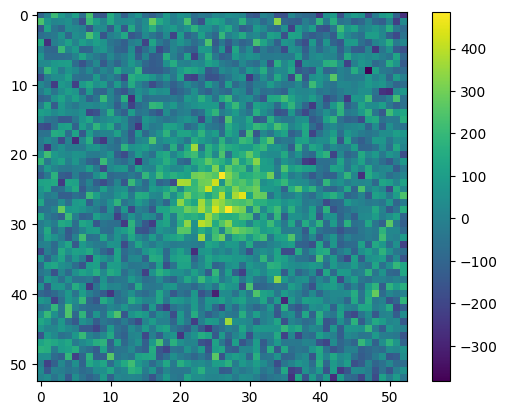

In [10]:
im_nn = _draw_gal()
im = add_noise(im_nn, BACKGROUND)[0][0] ## does not add background just noise
plt.imshow(im)
plt.colorbar()

In [11]:
print(get_snr(im_nn, BACKGROUND))

28.82505


In [12]:
# jax drawing
GSPARAMS = xgalsim.GSParams(minimum_fft_size=256, maximum_fft_size=256)

@jjit
def draw_gal(f):
    gal = xgalsim.Gaussian(flux=10**f, half_light_radius=HLR)
    psf = xgalsim.Gaussian(flux=1., half_light_radius=PSF_HLR)
    gal_conv = xgalsim.Convolve([gal, psf]).withGSParams(GSPARAMS)
    image = gal_conv.drawImage(nx=SLEN,ny=SLEN,scale=PIXEL_SCALE,
                                 )
    return image.array

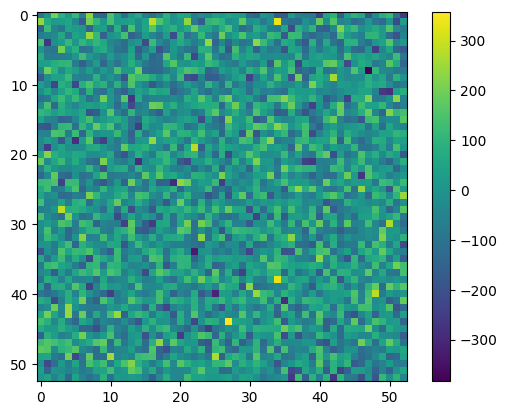

In [13]:
res = im - draw_gal(**TRUE_PARAMS)
plt.imshow(res)
plt.colorbar()

# Blackjax inference for a single noisy image

We follow the quickstart tutorial and do some warmup: https://blackjax-devs.github.io/blackjax/examples/quickstart.html

In [18]:
Y1= jax.device_put(im, device=jax.devices('gpu')[0]) # make sure target data is in GPU
Y1.devices()

{CudaDevice(id=0)}

In [23]:
def logdensity_fn(f):
    """Univariate Normal"""
    
    #prior
    prior = stats.uniform.logpdf(f, 4, 1) 
    
    # likelihood
    model = draw_gal(f)
    likelihood = stats.norm.logpdf(Y1, loc=model, scale=jnp.sqrt(BACKGROUND))
    
    return prior + jnp.sum(likelihood)

logdensity = lambda x: logdensity_fn(**x)

In [24]:
def inference_loop(rng_key, step_fn, initial_state, num_samples):
    
    @jax.jit
    def one_step(state, rng_key):
        state, _ = step_fn(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [25]:
rng_key = jax.random.key(44)

In [26]:
%%time

# warmup
initial_position = {'f': LOG_FLUX}
warmup = blackjax.window_adaptation(blackjax.nuts, logdensity)
rng_key, warmup_key, sample_key = jax.random.split(rng_key, 3)
(state, parameters), _ = warmup.run(warmup_key, initial_position, num_steps=1000)

CPU times: user 4.46 s, sys: 295 ms, total: 4.75 s
Wall time: 4.48 s


In [27]:
parameters

{'step_size': Array(1.09258225, dtype=float64, weak_type=True),
 'inverse_mass_matrix': Array([0.00022831], dtype=float64)}

In [28]:
%%time

kernel = jax.jit(blackjax.nuts(logdensity, **parameters).step)
states = inference_loop(sample_key, kernel, state, 1_000)


CPU times: user 3.14 s, sys: 100 ms, total: 3.25 s
Wall time: 2.86 s


In [29]:
mcmc_samples = states.position

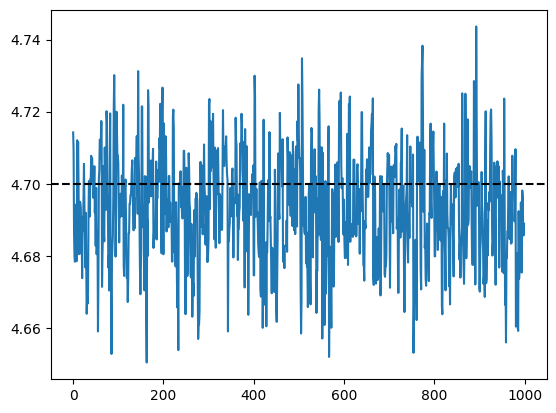

In [30]:
plt.plot(mcmc_samples['f'])
plt.axhline(4.7, color='k', linestyle='--')

# Blackjax vmap example

Let's try to understand what is happening in this example, including the shapes of the different variables involved when passed into the `logdensity` function.

## Single chain timings

In [30]:
import numpy as np

import jax
import jax.numpy as jnp
import jax.scipy.stats as stats


loc, scale = 10, 20
observed = np.random.normal(loc, scale, size=1_000)
observed_jax = jax.device_put(observed, device=jax.devices('gpu')[0])


def logdensity_fn(loc, log_scale, observed=observed_jax):
    """Univariate Normal"""
    scale = jnp.exp(log_scale)
    logpdf = stats.norm.logpdf(observed, loc, scale)
    return jnp.sum(logpdf)


def logdensity(x):
    return logdensity_fn(**x)

def inference_loop(rng_key, kernel, initial_state, num_samples):
    # one chain

    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [31]:
import blackjax


inv_mass_matrix = np.array([0.5, 0.01])
step_size = 1e-3

nuts = blackjax.nuts(logdensity, step_size, inv_mass_matrix)

In [47]:
# check runtime of 1 chain, no vmapping
n_steps = 750

initial_positions = {"loc": 1., "log_scale": 1.}
initial_states = nuts.init(initial_positions)

In [48]:
rng_key = jax.random.key(42)
rng_key, sample_key = jax.random.split(rng_key)
kernel = jax.jit(nuts.step)

In [51]:
%%time

states = inference_loop(
    sample_key, kernel, initial_states, n_steps
)
x = states.position["loc"].block_until_ready()
x.shape

CPU times: user 1min 17s, sys: 115 ms, total: 1min 18s
Wall time: 1min 17s


(750,)

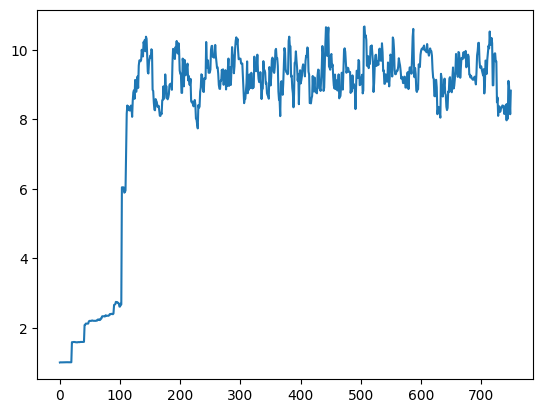

In [52]:
plt.plot(x)

## Multiple chains vmap 

In [67]:
def inference_loop_multiple_chains(
    rng_key, kernel, initial_state, num_samples, num_chains
):

    @jax.jit
    def one_step(states, rng_key):
        keys = jax.random.split(rng_key, num_chains)
        states, _ = jax.vmap(kernel)(keys, states)
        return states, states

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states


In [75]:
n_chains = 10000
n_steps = 750

In [76]:
initial_positions = {"loc": np.ones(n_chains), "log_scale": np.ones(n_chains)}
initial_states = jax.vmap(nuts.init, in_axes=(0))(initial_positions)
# initial_states

In [77]:
kernel = jax.jit(nuts.step)

In [78]:
rng_key = jax.random.key(42)

In [79]:
%%time
rng_key, sample_key = jax.random.split(rng_key)
states = inference_loop_multiple_chains(
    sample_key, kernel, initial_states, n_steps, n_chains
)
_ = states.position["loc"].block_until_ready()

CPU times: user 2min 5s, sys: 169 ms, total: 2min 5s
Wall time: 2min 4s


In [80]:
states.position["loc"].shape

(750, 10000)

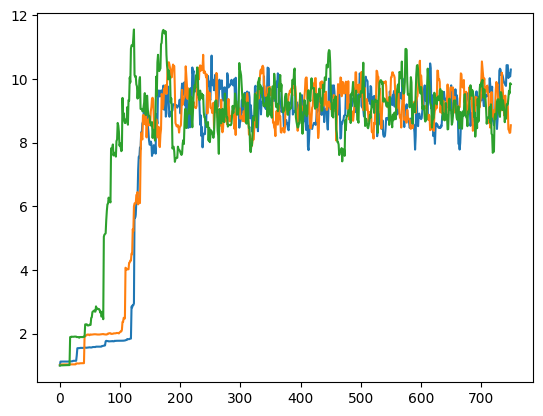

In [81]:
plt.plot(states.position["loc"][:, 0])
plt.plot(states.position["loc"][:, 10])
plt.plot(states.position["loc"][:, 20])

In [87]:
# less chains? 
num_chains = 1
initial_positions = {"loc": np.ones(num_chains), "log_scale": np.ones(num_chains)}
initial_states = jax.vmap(nuts.init, in_axes=(0))(initial_positions)


In [ ]:
%%time
rng_key, sample_key = jax.random.split(rng_key)
states = inference_loop_multiple_chains(
    sample_key, jax.jit(nuts.step), initial_states, 2_000, num_chains
)
_ = states.position["loc"].block_until_ready()

In [86]:
states.position["loc"].shape

(2000, 5)

# Try vmap with jax-galsim fitting

Here we want to run multiple chains in parallel over different images with different noise realizations all in one GPU.
The reference here might be useful: https://blackjax-devs.github.io/blackjax/examples/howto_sample_multiple_chains.html

In [207]:
# data 
im_nn = _draw_gal()
Y, _ = add_noise(im_nn, BACKGROUND, n=10)
Y.shape

(10, 53, 53)

In [208]:
Y = jax.device_put(Y, device=jax.devices('gpu')[0])

In [209]:
Y[0].max(), Y[1].max() #different

(Array(506.29931409, dtype=float64), Array(523.04589974, dtype=float64))

In [210]:
draw_gal_vect = jax.vmap(draw_gal)

In [217]:
def logdensity_fn(params, data):
    """Univariate Normal"""
    f = params['f']
    
    #prior
    prior = stats.uniform.logpdf(f, 4, 1) 
    
    # likelihood
    model = draw_gal(f)
    
    likelihood = stats.norm.logpdf(data, loc=model, scale=jnp.sqrt(BACKGROUND))
    
    return jnp.sum(prior) + jnp.sum(likelihood)

logdensity = lambda x: logdensity_fn(**x)

def inference_loop(rng_key, kernel, initial_state, num_samples):
    # one chain

    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

def inference_loop_multiple_chains(
    rng_key, kernel, initial_state, num_samples, num_chains
):

    @jax.jit
    def one_step(states, rng_key):
        keys = jax.random.split(rng_key, num_chains)
        states, _ = jax.vmap(kernel)(keys, states)
        return states, states

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [227]:
from functools import partial
N_STEPS = 1000
def run_one_chain(rng_key, data, logdensity_fn):
    inv_mass_matrix = jnp.array([0.00025718])
    step_size = .8204235

    logdensity = partial(logdensity_fn, data=data)
    nuts = blackjax.nuts(logdensity, step_size, inv_mass_matrix)
    
    initial_positions = {"f": 4.1}
    initial_states = nuts.init(initial_positions)
    
    rng_key, sample_key = jax.random.split(rng_key)

    states = inference_loop(
        sample_key, nuts.step, initial_states, N_STEPS,
    )
    return states.position['f']

run_chain = partial(run_one_chain, logdensity_fn=logdensity_fn)


In [228]:
%%time
rng_key = jax.random.key(44)
_samples = run_chain(rng_key, Y[10])

CPU times: user 3.98 s, sys: 102 ms, total: 4.08 s
Wall time: 3.73 s


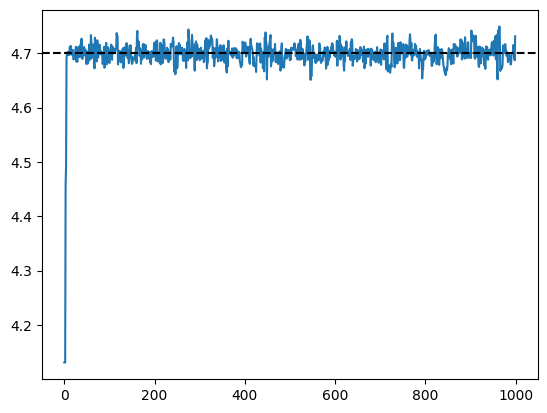

In [229]:
plt.plot(_samples)
plt.axhline(4.7, color='k', linestyle='--')

In [215]:
%%time
n_chains = Y.shape[0]
rng_key = jax.random.key(42)
keys = jax.random.split(rng_key, n_chains)

run_multiple_chains = jax.vmap(run_chain)
samples = run_multiple_chains(keys, Y)

CPU times: user 5.63 s, sys: 122 ms, total: 5.76 s
Wall time: 4.68 s


In [216]:
samples.shape

(10, 1000)

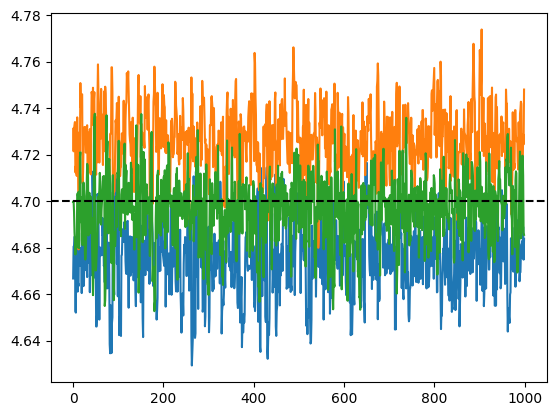

In [202]:
plt.plot(samples[0])
plt.plot(samples[11])
plt.plot(samples[20])
plt.axhline(4.7, color='k', linestyle='--')

In [46]:
# we will use the mass matrix of the sample from the last section
inv_mass_matrix = jnp.array([0.00025718])
step_size = .8204235

nuts = blackjax.nuts(logdensity, step_size, inv_mass_matrix)

In [48]:
initial_positions = {"f": jnp.ones(len(Y)) * LOG_FLUX}
initial_states = jax.vmap(nuts.init, in_axes=(0))(initial_positions)


In [313]:
rng_key, sample_key = jax.random.split(rng_key)
states = inference_loop_multiple_chains(
    sample_key, nuts.step, initial_states, 2_000, 100,
)
_ = states.position["loc"].block_until_ready()

ValueError: vmap was requested to map its argument along axis 0, which implies that its rank should be at least 1, but is only 0 (its shape is ())

In [229]:
(jnp.ones(len(y)) * LOG_FLUX).shape

(100,)